In [ ]:
# ===== 모델 초기화 (Apple Silicon Metal GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# Metal GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Metal GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # Metal에서는 memory_growth 설정하지 않음 (오히려 문제 발생)
    print("✅ Apple Silicon Metal GPU 활성화됨!")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# 간단한 GPU 테스트
print("\n=== GPU 연산 테스트 ===")
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"GPU 연산 테스트 완료: shape = {c.shape}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 Metal GPU 초기화 완료")

TensorFlow 버전: 2.16.2
✅ Metal GPU 발견: 1개
   - /physical_device:GPU:0
✅ Apple Silicon Metal GPU 활성화됨!

=== GPU 연산 테스트 ===
GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 Metal GPU 초기화 완료

✅ TensorFlow 및 Metal GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [49]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.16.2
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [50]:
# ===== 1) 설정 =====
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_data_static.csv"
TARGET_COL = "status"
EMBEDDING_DIM = 2  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 64  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=2, 배치 크기=64, 에폭=200


In [51]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 57)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'status']

처음 5행:
   length_url  length_hostname  ip  nb_dots  nb_hyphens  nb_at

In [52]:
# ===== 3) 피처 및 레이블 분리 =====
# 'id' 컬럼이 있다면 제거
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
# 모델 출력도 동일: 0에 가까우면 정상, 1에 가까우면 피싱
y = df[TARGET_COL].values
y_binary = y.astype(np.float32)  # 그대로 사용

# 피처 추출 (타겟 제외)
X = df.drop(columns=[TARGET_COL]).values.astype(np.float32)

print(f"피처 shape: {X.shape}")
print(f"레이블 shape: {y_binary.shape}")
print(f"레이블 분포: 정상(0)={np.sum(y_binary==0)}, 피싱(1)={np.sum(y_binary==1)}")

# Train/Val/Test 분리 (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.4, stratify=y_binary, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

피처 shape: (11481, 56)
레이블 shape: (11481,)
레이블 분포: 정상(0)=5740, 피싱(1)=5741

Train: (6888, 56), Val: (2296, 56), Test: (2297, 56)


In [53]:
# ===== 4) 데이터 전처리 (스케일링 없음) =====
# Android에서 피처값 그대로 사용하기 위해 스케일링 제거

X_train_scaled = X_train.astype(np.float32)
X_val_scaled = X_val.astype(np.float32)
X_test_scaled = X_test.astype(np.float32)

print("데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)
Train 피처 범위: min=0.00, max=1641.00
피처 개수: 56개


In [54]:
# ===== 5) 분류 모델 구축 (Encoder + Classification Head) =====
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]

# Encoder 부분
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(128, activation='relu', name='encoder_dense1')(encoder_input)
x = layers.BatchNormalization(name='encoder_bn1')(x)
x = layers.Dropout(0.3, name='encoder_dropout1')(x)
x = layers.Dense(64, activation='relu', name='encoder_dense2')(x)
x = layers.BatchNormalization(name='encoder_bn2')(x)
x = layers.Dropout(0.2, name='encoder_dropout2')(x)
x = layers.Dense(32, activation='relu', name='encoder_dense3')(x)
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding')(x)

# Classification Head (분류 헤드)
x = layers.Dense(16, activation='relu', name='classifier_dense1')(embedding)
x = layers.Dropout(0.2, name='classifier_dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)  # 0: 피싱, 1: 정상

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 =====")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 =====


Model: "phishing_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense1 (Dense)       │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dropout (Dropout)    │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,531 (72.39 KB)

 Trainable params: 18,147 (70.89 KB)

 Non-trainable params: 384 (1.50 KB)


===== Encoder 모델 구조 =====


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense1 (Dense)          │ (None, 128)            │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn1                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout1 (Dropout)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout2 (Dropout)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,466 (72.13 KB)

 Trainable params: 18,082 (70.63 KB)

 Non-trainable params: 384 (1.50 KB)

In [55]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6819 - auc: 0.7382 - loss: 0.6073 - val_accuracy: 0.7243 - val_auc: 0.8312 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6819 - auc: 0.7382 - loss: 0.6073 - val_accuracy: 0.7243 - val_auc: 0.8312 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7445 - auc: 0.8099 - loss: 0.5356 - val_accuracy: 0.7557 - val_auc: 0.8459 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7445 - auc: 0.8099 - loss: 0.5356 - val_accuracy: 0.7557 - val_auc: 0.8459 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7731 - auc: 0.8492 - loss: 0.4866 - val_accuracy: 0.7761 - val_auc: 0.8832 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 4/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.77

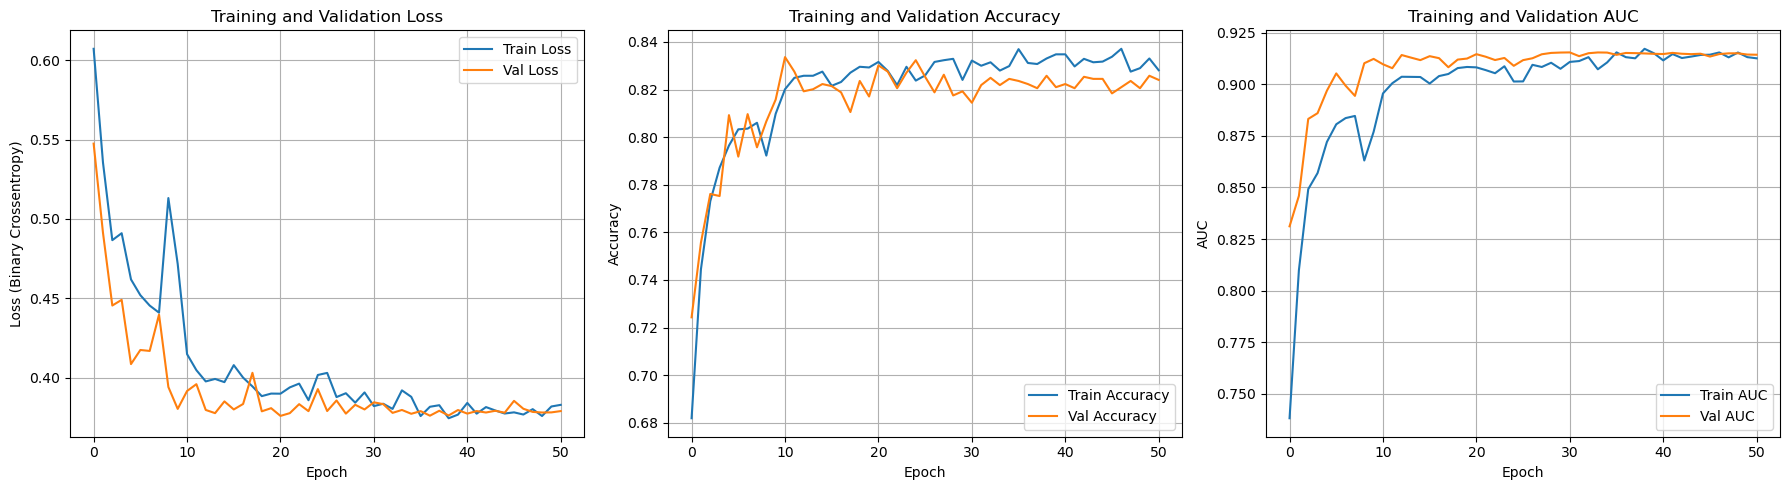

In [56]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [57]:
# ===== 8) 모델 평가 (Validation) =====
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)

print("===== Validation 세트 평가 결과 =====")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_binary = (pred_val > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_val, pred_val_binary, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Loss: 0.3758
Accuracy: 0.8301
AUC: 0.9146

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.83      0.83      0.83      1148
  Legitimate       0.83      0.83      0.83      1148

    accuracy                           0.83      2296
   macro avg       0.83      0.83      0.83      2296
weighted avg       0.83      0.83      0.83      2296


Classification Report:
              precision    recall  f1-score   support

    Phishing       0.83      0.83      0.83      1148
  Legitimate       0.83      0.83      0.83      1148

    accuracy                           0.83      2296
   macro avg       0.83      0.83      0.83      2296
weighted avg       0.83      0.83      0.83      2296



In [58]:
# ===== 9) 모델 평가 (Test) =====
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)

print("===== Test 세트 평가 결과 =====")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_binary = (pred_test > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_binary, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Loss: 0.3660
Accuracy: 0.8306
AUC: 0.9219

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.83      0.83      0.83      1148
  Legitimate       0.83      0.83      0.83      1149

    accuracy                           0.83      2297
   macro avg       0.83      0.83      0.83      2297
weighted avg       0.83      0.83      0.83      2297



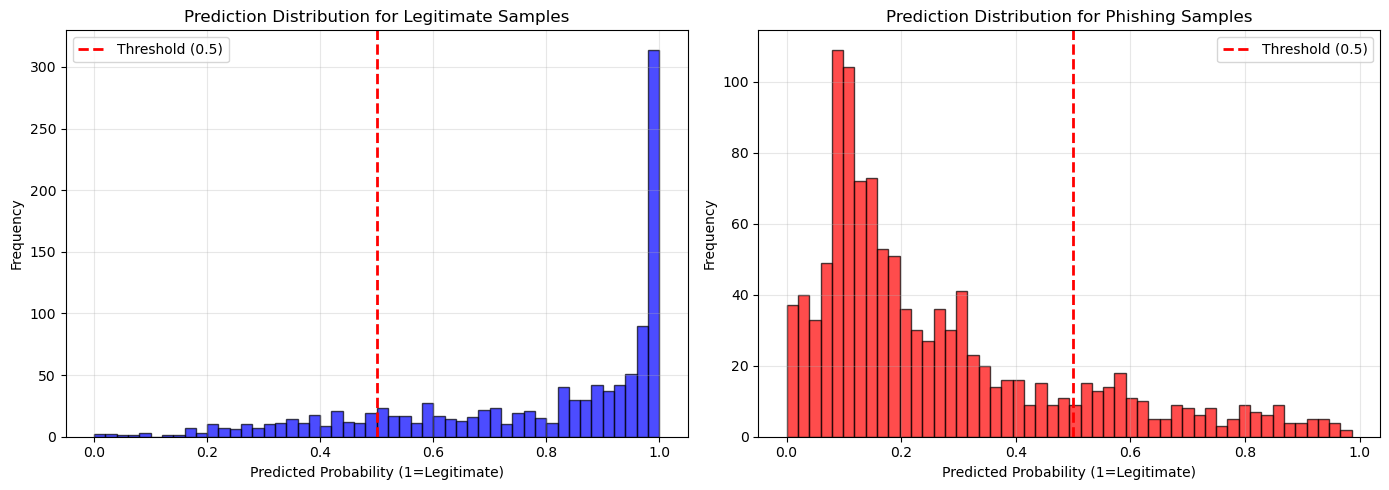


정상 사이트 평균 예측값: 0.7760
피싱 사이트 평균 예측값: 0.2635


In [59]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


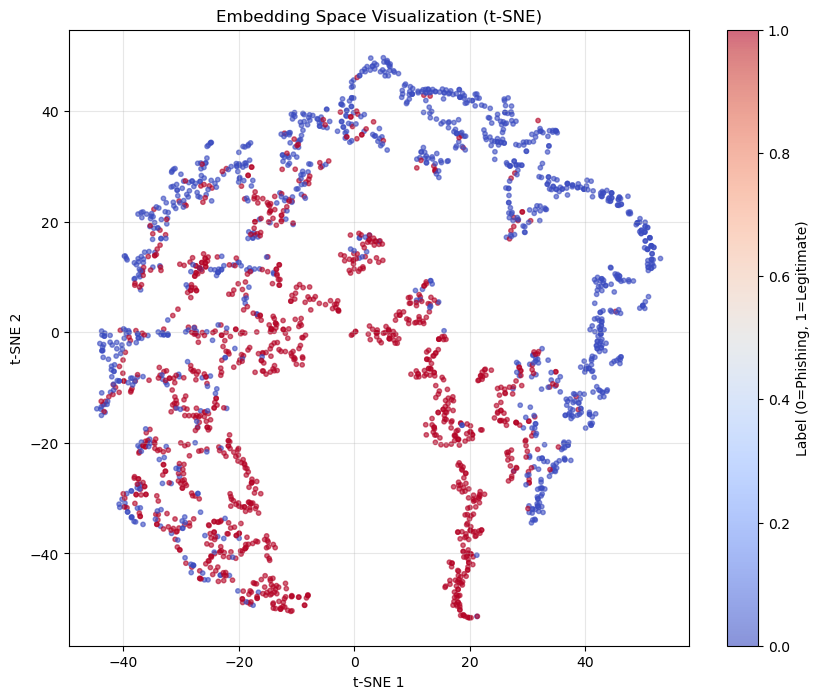

In [61]:
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Label (0=Phishing, 1=Legitimate)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
# ===== 12) 임베딩 공간 시각화 (t-SNE 2D & 3D 인터랙티브) =====
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# 예측값 기반 오분류 샘플 식별
# pred_binary = (pred_test.flatten() > 0.5).astype(int)
# misclassified = (pred_binary != y_test.astype(int))

print(f"테스트 샘플 수: {len(y_test)}")
# print(f"오분류 샘플 수: {misclassified.sum()} ({misclassified.sum()/len(y_test)*100:.1f}%)")

# ===== 3D t-SNE =====
print("\n3D t-SNE 변환 중...")
tsne_3d = TSNE(n_components=3, random_state=RANDOM_SEED, perplexity=30)
embeddings_3d = tsne_3d.fit_transform(embeddings_test)

# 인덱스 분리
legit_idx = (y_test == 0)
phish_idx = (y_test == 1)

# ===== Plotly 3D 인터랙티브 시각화 =====
fig = go.Figure()

# 정상 샘플 (파란색)
fig.add_trace(go.Scatter3d(
    x=embeddings_3d[legit_idx, 0],
    y=embeddings_3d[legit_idx, 1],
    z=embeddings_3d[legit_idx, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.6),
    name='Legitimate (0)'
))

# 피싱 샘플 (빨간색)
fig.add_trace(go.Scatter3d(
    x=embeddings_3d[phish_idx, 0],
    y=embeddings_3d[phish_idx, 1],
    z=embeddings_3d[phish_idx, 2],
    mode='markers',
    marker=dict(size=3, color='red', opacity=0.6),
    name='Phishing (1)'
))

# 오분류 샘플 (검은 테두리)
# fig.add_trace(go.Scatter3d(
#     x=embeddings_3d[misclassified, 0],
#     y=embeddings_3d[misclassified, 1],
#     z=embeddings_3d[misclassified, 2],
#     mode='markers',
#     marker=dict(size=6, color='yellow', opacity=0.9,
#                 line=dict(color='black', width=2)),
#     name='Misclassified'
# ))

fig.update_layout(
    title='3D t-SNE Embedding Space (마우스로 회전 가능!)',
    scene=dict(
        xaxis_title='t-SNE 1',
        yaxis_title='t-SNE 2',
        zaxis_title='t-SNE 3'
    ),
    width=900,
    height=700,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

print(f"\n✅ 3D 인터랙티브 시각화 완료!")
print(f"   🖱️ 마우스 드래그: 회전")
print(f"   🔍 스크롤: 줌 인/아웃")
print(f"   - 파란점: 정상(Legitimate) 샘플")
print(f"   - 빨간점: 피싱(Phishing) 샘플") 
print(f"   - 노란점(검은테두리): 오분류된 샘플")

테스트 샘플 수: 2297

3D t-SNE 변환 중...


ValueError: n_components=3 must be between 1 and min(n_samples, n_features)=2 with svd_solver='randomized'

In [16]:
# ===== 13) 모델 저장 및 TFLite 변환 =====
import os

# 모델 경로 설정
OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "url_static_model.h5")
SAVED_MODEL_PATH = os.path.join(OUTPUT_DIR, "url_static_saved_model")
TFLITE_PATH = os.path.join(OUTPUT_DIR, "url_static_model.tflite")

# 1) Classifier 모델 H5로 저장
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("H5 모델 저장 완료!")

# 2) SavedModel 형식으로 저장
print(f"SavedModel로 저장 중: {SAVED_MODEL_PATH}")
classifier.export(SAVED_MODEL_PATH)
print("SavedModel 저장 완료!")

# 3) SavedModel에서 TFLite로 변환
print("TFLite 변환 중...")
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 4) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Classifier 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_model.h5
H5 모델 저장 완료!
SavedModel로 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model
INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model/assets


INFO:tensorflow:Assets written to: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model/assets


Saved artifact at '/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 56), dtype=tf.float32, name='encoder_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13608516976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13608517152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609288976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609289328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609288624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609288800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609289152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609290384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609289856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13609289680: TensorSpec(shape=(), dtype=tf.resource, name=

W0000 00:00:1764251045.582190 1783526 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1764251045.582818 1783526 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-11-27 22:44:05.583381: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model
2025-11-27 22:44:05.583805: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-11-27 22:44:05.583809: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_saved_model
2025-11-27 22:44:05.591239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-11-27 22:44:05.592112: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-11-27 22:44:05.622233: I tensorflow/cc/saved_model/loader.cc:218

✅ TFLite 모델 저장 완료: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/url_static_model.tflite
📦 모델 크기: 78.75 KB

입력 shape: [ 1 56]
출력 shape: [1 1]
✅ TFLite 모델 검증 완료!


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
